In [76]:
import matplotlib.pyplot as plt
import matplotlib.image as pltImg
import pandas as pd
import numpy as np
import cv2
%matplotlib inline
# %matplotlib notebook

In [77]:
path_csvFile = '../test_dataset/robot_log.csv'
data = pd.read_csv(path_csvFile)
images = np.array([pltImg.imread(img) for img in data['Path']])
yaws = data['Yaw']
X_Position = data['X_Position']
Y_Position = data['Y_Position']

In [78]:
def color_threshold(image, threshold = (180, 180, 180)):
    output = np.zeros_like(image[:,:,0])
    above_threshold = ((image[:,:,0] > threshold[0]) &
                      (image[:,:,1] > threshold[1]) &
                      (image[:,:,2] > threshold[2]))
    output[above_threshold] = 1
    return output

def warpedImg(image, src = None, dst = None):
    dst_size = 5
    bottom_offset = 6
    image = images[0]
    source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
    destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                      [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                      [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                      [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                      ])
    M = cv2.getPerspectiveTransform(source, destination)
    warped = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]))
    
    return warped

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated

def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

In [79]:
def MAP(num_frame):
    test_img = images[num_frame]
    thre_1 = warpedImg(test_img)
    thre_1 = color_threshold(thre_1)
    
    raw_ypos, raw_xpos = thre_1.nonzero()

    xpix, ypix = rover_coords(thre_1)
    yaw = yaws[num_frame]
    xpos = X_Position[num_frame]
    ypos = Y_Position[num_frame]

    x_rotated, y_rotated = rotate_pix(xpix, ypix, yaw)
    
    # Assume a scale factor of 10 between world space pixels and rover space pixels
    scale = 10
    # Perform translation and convert to integer since pixel values can't be float
    x_world = np.int_(xpos + (x_rotated / scale))
    y_world = np.int_(ypos + (y_rotated / scale))
    
    return x_world, y_world

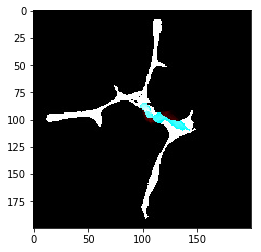

In [85]:
pathImg = pltImg.imread('../calibration_images/map_bw.jpg')

for i in range(len(images)):
    x_rotated, y_rotated = MAP(i)
    pathImg[y_rotated,x_rotated] += np.uint8([2, 0, 0])
plt.imshow(pathImg)